<a href="https://colab.research.google.com/github/kordusmonika/dw_matrix_car/blob/master/day3_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install eli5
!pip install --upgrade tables

In [3]:
cd /content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_2/dw_matrix_car/data

/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_2/dw_matrix_car/data


In [4]:
import pandas as pd
import numpy as np

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score

import eli5
from eli5.sklearn import PermutationImportance

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


#Data load

In [6]:
df = pd.read_hdf('car.h5')
df.shape

(106494, 155)

In [7]:
df.columns

Index(['breadcrumb', 'created_at', 'price_currency', 'price_details',
       'price_value', 'seller_address', 'seller_name', 'seller_type',
       'feature_czujniki-parkowania-przednie',
       'feature_poduszka-powietrzna-chroniąca-kolana',
       ...
       'param_pearl', 'param_stan', 'param_wersja', 'param_emisja-co2',
       'param_body-type', 'param_matowy', 'param_bezwypadkowy',
       'param_akryl-(niemetalizowany)', 'param_monthly-payment-value',
       'car_id'],
      dtype='object', length=155)

#Dummy Model

In [8]:
#Achieved 39 tys zl. MAE aims to 0

X = df[ ['car_id'] ].values
y = df['price_value'].values

model = DummyRegressor()
model.fit(X,y)
y_pred = model.predict(X)

mae(y, y_pred)

39465.934630440985

In [9]:
[x for x in df.columns if 'price' in x]

['price_currency', 'price_details', 'price_value']

In [10]:
df['price_currency'].value_counts()

PLN    106290
EUR       204
Name: price_currency, dtype: int64

In [0]:
#We will delete EUR
df = df[ df['price_currency'] != 'EUR' ]

In [12]:
df['price_currency'].value_counts()

PLN    106290
Name: price_currency, dtype: int64

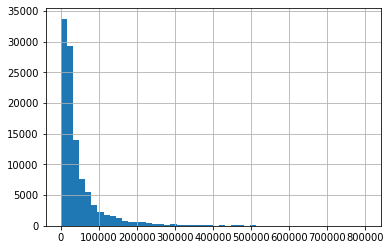

In [13]:
df['price_value'].hist(bins=50)

#Feature engineering

In [0]:
SUFIX_CAT = '__cat'

for feat in df.columns:
  if isinstance(df[feat][0], list): continue

  factorized_values = df[feat].factorize()[0]
  if SUFIX_CAT in feat:
    df[feat] = factorized_values
  else:
    df[ feat + SUFIX_CAT ] = factorized_values

In [36]:
cat_feats = [x for x in df.columns if SUFIX_CAT in x]
cat_feats = [x for x in cat_feats if 'price' not in x]
len(cat_feats)

151

In [37]:
X = df[cat_feats].values
y = df['price_value'].values

model = DecisionTreeRegressor(max_depth=5)
scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_absolute_error')
np.mean(scores)

-19650.45289201444

In [40]:
#Check the importance of features
m = DecisionTreeRegressor(max_depth=5)
m.fit(X,y)

imp = PermutationImportance(m, random_state=0 ).fit(X,y)
eli5.show_weights(imp, feature_names = cat_feats)

Weight,Feature
0.1956 ± 0.0054,param_faktura-vat__cat
0.1903 ± 0.0027,param_napęd__cat
0.1815 ± 0.0087,param_stan__cat
0.1512 ± 0.0078,param_rok-produkcji__cat
0.0928 ± 0.0019,param_skrzynia-biegów__cat
0.0607 ± 0.0051,param_moc__cat
0.0436 ± 0.0015,feature_kamera-cofania__cat
0.0191 ± 0.0022,param_pojemność-skokowa__cat
0.0162 ± 0.0004,feature_bluetooth__cat
0.0110 ± 0.0007,feature_łopatki-zmiany-biegów__cat
